In [5]:
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from testing import TestBuilder
from database import connection
from controllers import user, poll
from testcontainers.mongodb import MongoDbContainer
from testcontainers.postgres import PostgresContainer

In [6]:
# Create a plot to compare 2 sets of data.

def create_plot_comparison(labels, a_data, b_data, a_label, b_label, x_label, y_label, title):
    X_axis = np.arange(len(labels))

    plt.bar_label(plt.bar(X_axis - 0.2, a_data, 0.4, label = a_label), padding=3)
    plt.bar_label(plt.bar(X_axis + 0.2, b_data, 0.4, label = b_label), padding=3)

    plt.xticks(X_axis, labels)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

## Tests running on local docker containerized tests 

In [7]:
importlib.reload(connection)

# Run tests on MongoDB in container.

with MongoDbContainer("mongo:latest") as mongo:
    con = connection.ContainerMongoConnection(mongo)
    tests = TestBuilder(con, con, user.UserControllerMongo, poll.PollControllerMongo)
    mongo_test_results = tests.run_all(1000, 1000)

Pulling image mongo:latest


Container started: 969f52d6ddf7
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...


In [8]:
importlib.reload(connection)

# Run tests on MongoDB using reference in container.

with MongoDbContainer("mongo:latest") as mongo:
    con = connection.ContainerMongoConnection(mongo)
    tests = TestBuilder(con, con, user.UserControllerMongo, poll.PollControllerMongoReferenced)
    mongo_ref_test_results = tests.run_all(1000, 1000)

Pulling image mongo:latest


Container started: e5635a98d276
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...


In [9]:
importlib.reload(connection)

# Run tests on MongoDB using aggregate in container.

with MongoDbContainer("mongo:latest") as mongo:
    con = connection.ContainerMongoConnection(mongo)
    tests = TestBuilder(con, con, user.UserControllerMongoAggregate, poll.PollControllerMongo)
    mongo_aggregate_test_results = tests.run_all(1000, 1000)

Pulling image mongo:latest


Container started: 072cffbd07b4
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...


In [10]:
importlib.reload(connection)

# Run tests on MongoDB using an index on the Polls collection.

with MongoDbContainer("mongo:latest") as mongo:
    con = connection.ContainerMongoConnection(mongo)
    con.db["users"].create_index("user_index", unique=True)
    tests = TestBuilder(con, con, user.UserControllerMongo, poll.PollControllerMongo)
    mongo_index_test_results = tests.run_all(1000, 1000)

Pulling image mongo:latest


Container started: 8d3d32ae2672
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...


In [11]:
importlib.reload(connection)

# Run tests on Postgres in container.

with PostgresContainer("postgres:latest") as postgres:
    con = connection.ContainerSQLConnection(postgres)
    tests = TestBuilder(con, con, user.UserControllerSql, poll.PollControllerSql)
    psql_test_results = tests.run_all(1000, 1000)

Pulling image postgres:latest


Container started: 3a4bd4f6a7f4
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...
Waiting to be ready...


## Tests running on MongoDB Atlas connection

In [18]:
importlib.reload(connection)

con = connection.MongoConnection("connection str", "test")
tests = TestBuilder(con, con, user.UserControllerMongo, poll.PollControllerMongo)
mongo_atlas_test_results = tests.run_all(100, 100)
con.client.close()

## Tests running on PostgreSQL Elephant connection

In [19]:
importlib.reload(connection)

con = connection.SQLConnection("horton.db.elephantsql.com", "db_name", "user", "pass")
tests = TestBuilder(con, con, user.UserControllerSql, poll.PollControllerSql)
psql_cloud_test_results = tests.run_all(100, 100)

## Comparison of various operations between MongoDB and PostgreSQL on the local machine

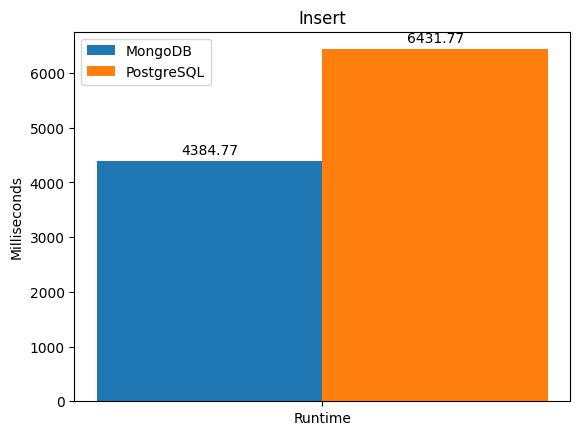

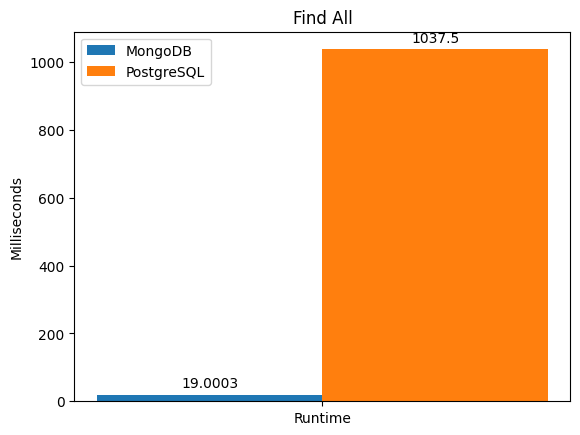

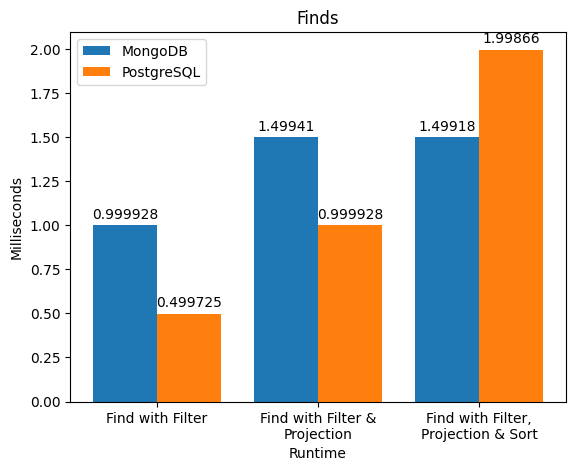

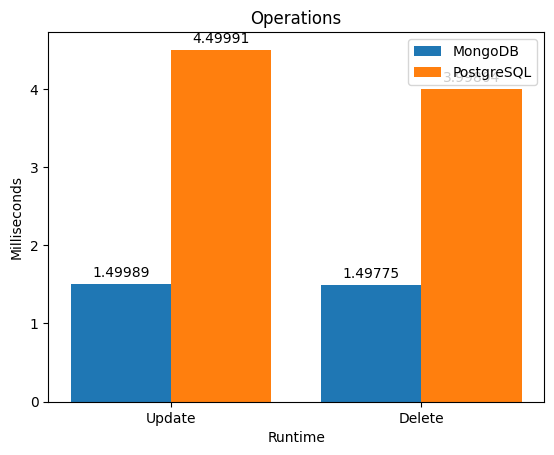

In [14]:
create_plot_comparison(["Runtime"], [mongo_test_results["bulk_insertion"]*1000], [psql_test_results["bulk_insertion"]*1000], "MongoDB", "PostgreSQL", "", "Milliseconds", "Insert")

create_plot_comparison(["Runtime"], [mongo_test_results["find_all"]*1000], [psql_test_results["find_all"]*1000], "MongoDB", "PostgreSQL", "", "Milliseconds", "Find All")

create_plot_comparison(["Find with Filter", "Find with Filter &\nProjection", "Find with Filter,\nProjection & Sort"], [mongo_test_results["find_filter"]*1000, mongo_test_results["find_filter_projection"]*1000, mongo_test_results["filter_project_sort"]*1000], [psql_test_results["find_filter"]*1000, psql_test_results["find_filter_projection"]*1000, psql_test_results["filter_project_sort"]*1000], "MongoDB", "PostgreSQL", "Runtime", "Milliseconds", "Finds")

create_plot_comparison(["Update", "Delete"], [mongo_test_results["update"]*1000, mongo_test_results["delete"]*1000], [psql_test_results["update"]*1000, psql_test_results["delete"]*1000], "MongoDB", "PostgreSQL", "Runtime", "Milliseconds", "Operations")

## The next plot compares the usage of a search operation using MongoDB aggregate vs non-aggregates

Non-aggregated operations seem to be executed in half the time. 

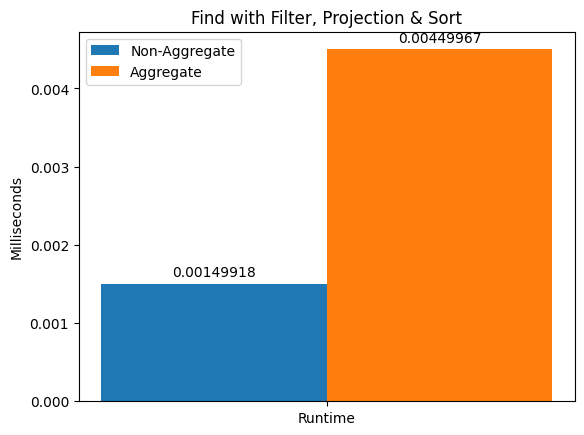

In [15]:
create_plot_comparison(["Runtime"], [mongo_test_results["filter_project_sort"]], [mongo_aggregate_test_results["filter_project_sort"]], "Non-Aggregate", "Aggregate", "", "Milliseconds", "Find with Filter, Projection & Sort")

## The next plot compares the usage of a model based on embedded doucments compared to references

Embedded documents seem to make a significant difference when it comes runtime probably because they are built-in while references need multiple finds to be executed.

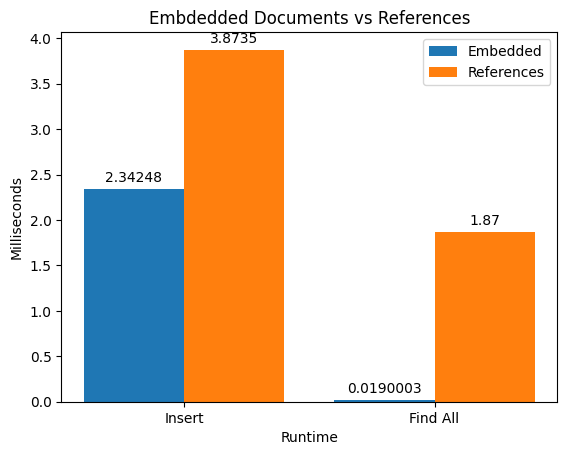

In [16]:
create_plot_comparison(["Insert", "Find All"], [mongo_test_results["bulk_insertion_with_polls"], mongo_test_results["find_all"]], [mongo_ref_test_results["bulk_insertion_with_polls"], mongo_ref_test_results["find_all"]], "Embedded", "References", "Runtime", "Milliseconds", "Embdedded Documents vs References")

## The next plot compares the find performance of an indexed collection to an unindexed collection

Surprisingly the find operation on the indexed collection performs worse than the one on the unindexed collection when it comes to runtime.

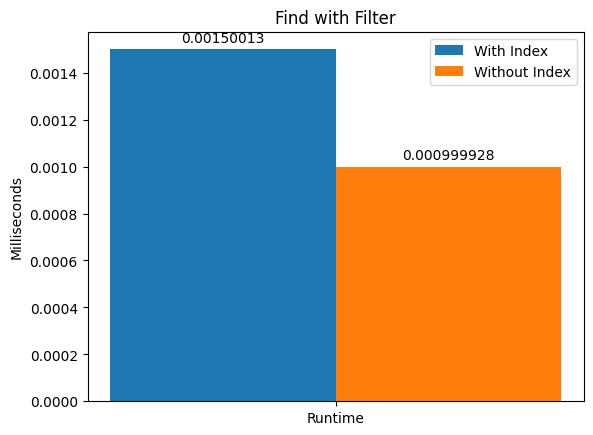

In [17]:
create_plot_comparison(["Runtime"], [mongo_index_test_results["find_filter"]], [mongo_test_results["find_filter"]], "With Index", "Without Index", "", "Milliseconds", "Find with Filter")

## Tests running on local MongoDB instances compared to tests running on MongoDB Atlas

The operations on MongoDB Atlas seem to take a lot longer in terms of runtime, this can be explained by the latency of the internet connection which is non-existent when using the local MongoDB instance.
Another factor could be that we are using the free shared cluster of MongoDB Atlas with lower performance than paid tiers.

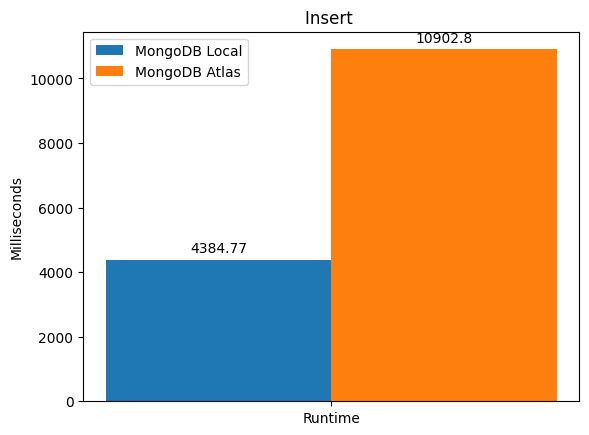

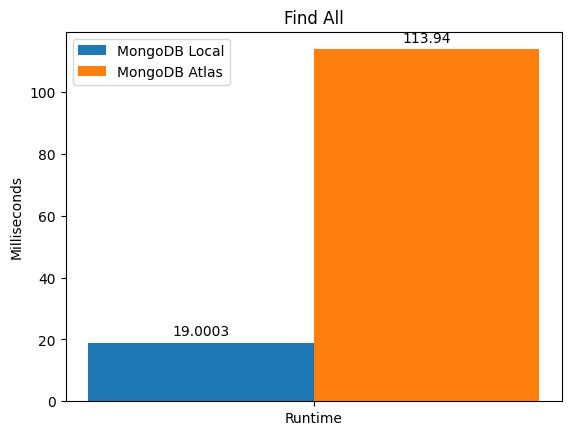

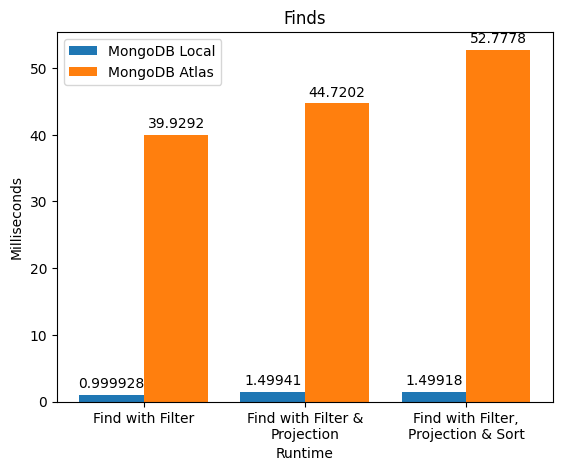

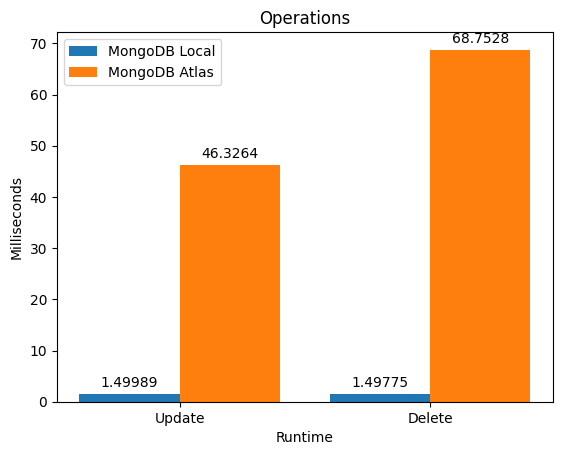

In [21]:

create_plot_comparison(["Runtime"], [mongo_test_results["bulk_insertion"]*1000], [mongo_atlas_test_results["bulk_insertion"]*1000], "MongoDB Local", "MongoDB Atlas", "", "Milliseconds", "Insert ")

create_plot_comparison(["Runtime"], [mongo_test_results["find_all"]*1000], [mongo_atlas_test_results["find_all"]*1000], "MongoDB Local", "MongoDB Atlas", "", "Milliseconds", "Find All")

create_plot_comparison(["Find with Filter", "Find with Filter &\nProjection", "Find with Filter,\nProjection & Sort"], [mongo_test_results["find_filter"]*1000, mongo_test_results["find_filter_projection"]*1000, mongo_test_results["filter_project_sort"]*1000], [mongo_atlas_test_results["find_filter"]*1000, mongo_atlas_test_results["find_filter_projection"]*1000, mongo_atlas_test_results["filter_project_sort"]*1000], "MongoDB Local", "MongoDB Atlas", "Runtime", "Milliseconds", "Finds")

create_plot_comparison(["Update", "Delete"], [mongo_test_results["update"]*1000, mongo_test_results["delete"]*1000], [mongo_atlas_test_results["update"]*1000, mongo_atlas_test_results["delete"]*1000], "MongoDB Local", "MongoDB Atlas", "Runtime", "Milliseconds", "Operations")

## Tests running on MongoDB Atlas compared to PostgreSQL Elephant Cloud

The runtime seems to be significantly lower on MongoDB Atlas, this may be due to MongoDB Atlas being a more popular cloud provider with more resources than Elpehant Cloud.  

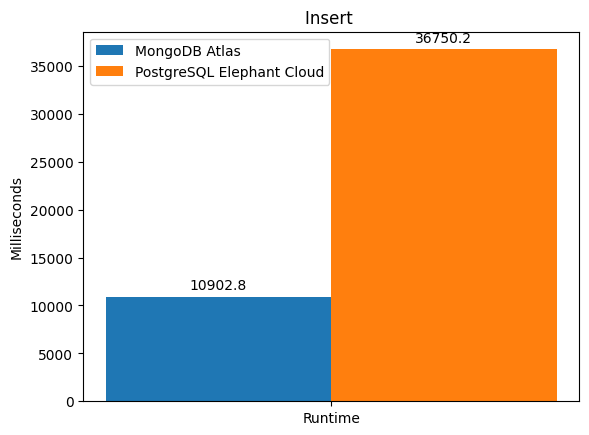

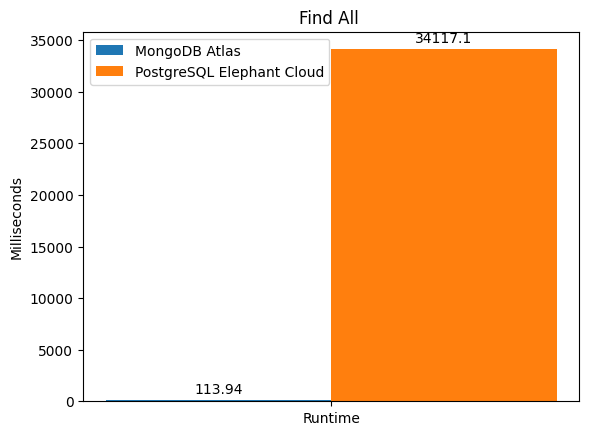

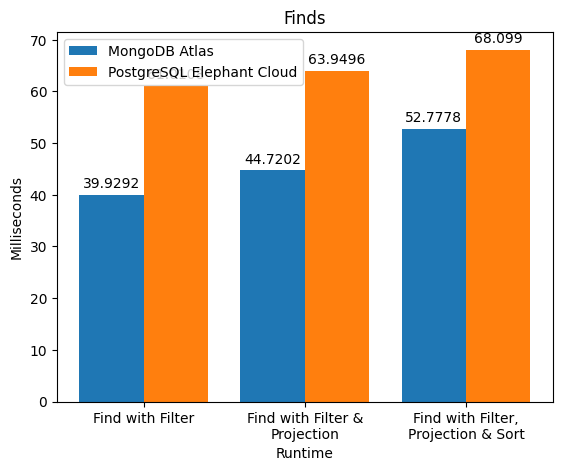

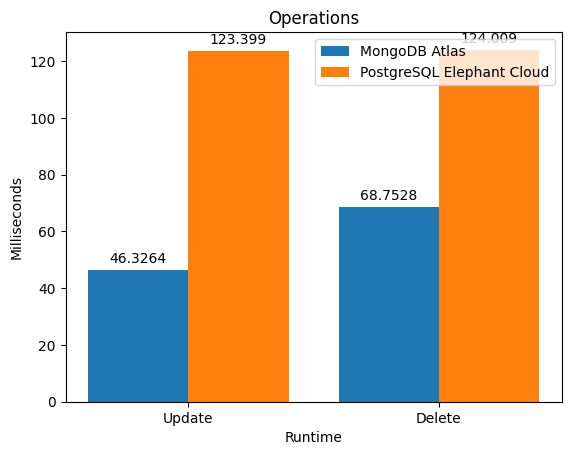

In [20]:
create_plot_comparison(["Runtime"], [mongo_atlas_test_results["bulk_insertion"]*1000], [psql_cloud_test_results["bulk_insertion"]*1000], "MongoDB Atlas", "PostgreSQL Elephant Cloud", "", "Milliseconds", "Insert ")

create_plot_comparison(["Runtime"], [mongo_atlas_test_results["find_all"]*1000], [psql_cloud_test_results["find_all"]*1000], "MongoDB Atlas", "PostgreSQL Elephant Cloud", "", "Milliseconds", "Find All ")

create_plot_comparison(["Find with Filter", "Find with Filter &\nProjection", "Find with Filter,\nProjection & Sort"], [mongo_atlas_test_results["find_filter"]*1000, mongo_atlas_test_results["find_filter_projection"]*1000, mongo_atlas_test_results["filter_project_sort"]*1000], [psql_cloud_test_results["find_filter"]*1000, psql_cloud_test_results["find_filter_projection"]*1000, psql_cloud_test_results["filter_project_sort"]*1000], "MongoDB Atlas", "PostgreSQL Elephant Cloud", "Runtime", "Milliseconds", "Finds")

create_plot_comparison(["Update", "Delete"], [mongo_atlas_test_results["update"]*1000, mongo_atlas_test_results["delete"]*1000], [psql_cloud_test_results["update"]*1000, psql_cloud_test_results["delete"]*1000], "MongoDB Atlas", "PostgreSQL Elephant Cloud", "Runtime", "Milliseconds", "Operations")